Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Using the AWS Batch Architecture for Protein Folding

This notebook allows you to predict multiple protein sequences from the CAMEO data set between 2022-04-08 and 2022-07-02

## Table of Contents
0. [Install Dependencies](#0.-Install-Dependencies)
1. [Get target list](#1.-Get-target-list)
2. [Run MSA generation and folding jobs](#2.-Run-MSA-generation-and-folding-jobs) 
3. [Download results](#3.-Download-results)
4. [Visualze results](#4.-Visualize-results)
5. [Compare result to experimental structure](#5.-Compare-result-to-experimental-structure)

## 0. Install Dependencies

In [1]:
# Import required Python packages

import boto3
from datetime import datetime
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.jackhmmer_job import JackhmmerJob
from batchfold.openfold_job import OpenFoldJob
from batchfold.alphafold2_job import AlphaFold2Job
from batchfold.batchfold_target import BatchFoldTarget
import matplotlib.pyplot as plt
from nbhelpers import nbhelpers
import os
import json
import pandas as pd
import requests
import numpy as np

# Get client information
boto_session = boto3.session.Session()
batch_environment = BatchFoldEnvironment(boto_session = boto_session)

S3_BUCKET = batch_environment.default_bucket
print(f" S3 bucket name is {S3_BUCKET}")

s3 = boto_session.client("s3")

 S3 bucket name is batchfold-220804-container-1n1e-batchfolds3bucket-5qxhoqyc5dx8


## 1. Get targets

In [28]:
targets = pd.read_csv("1_month_cameo_benchmarking_targets.csv", header=0)    

## 2. Run MSA and Folding Jobs

In [3]:
import requests 
from Bio import SeqIO
from io import StringIO

for _, row in targets.iterrows():
    print(row["SEQ_ID"])
    target = BatchFoldTarget(target_id=row["SEQ_ID"], s3_bucket=S3_BUCKET, boto_session=boto_session)    
    fasta_string = requests.get(row["SEQ_URL"]).content.decode("utf-8")
    with StringIO(fasta_string) as fasta:
        for record in SeqIO.parse(fasta, "fasta"):
            target.add_sequence(
                seq_id=row["SEQ_ID"],
                seq=str(record.seq),
                description=record.description
            )

    # job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
    # jackhmmer_job = JackhmmerJob(
    #     job_name = job_name,
    #     target_id = target.target_id,
    #     fasta_s3_uri = target.get_fasta_s3_uri(),
    #     output_s3_uri = target.get_msas_s3_uri(),
    #     boto_session = boto_session,
    #     cpu = 16,
    #     memory = 31
    # )

    job_name = target.target_id + "_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
    openfold_job = OpenFoldJob(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri(),
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        config_preset = "model_1_ptm",
        openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
        save_outputs = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )

    # job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
    # alphafold2_job = AlphaFold2Job(
    #     job_name = job_name,
    #     boto_session = boto_session,
    #     target_id = target.target_id,
    #     fasta_s3_uri = target.get_fasta_s3_uri(),
    #     msa_s3_uri = target.get_msas_s3_uri(),
    #     output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
    #     use_precomputed_msas = True,
    #     model_preset = "monomer_ptm",    
    #     benchmark = True,
    #     cpu = 4,
    #     memory = 15, # Why not 16? ECS needs about 1 GB for container services
    #     gpu = 1
    # )    

    # jackhmmer_submission = batch_environment.submit_job(jackhmmer_job, job_queue_name="GravitonOnDemandJobQueue")

    # openfold_submission = batch_environment.submit_job(openfold_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])
    # alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])    

    openfold_submission = batch_environment.submit_job(openfold_job, job_queue_name="G4dnJobQueue")




7FAC_A
7PC1_A
7PCE_A
7R0O_B
7RPN_A
7SBD_H
7UQV_D
7V2S_B
7WUA_A
7X1K_A
7Y39_B
7ZVA_A
8A4A_A
8DT0_A
8DT6_C
8DTE_A
7DZ2_C
7FGB_A
7FH0_B
7LT7_A
7LX4_A
7MJ3_A
7R49_B
7RLK_D
7RMY_A
7S03_A
7SAO_A
7SNC_A
7SOO_A
7U0E_H
8AHP_A
7FAX_A
7FIA_A
7N7G_A
7P43_B
7P4A_A
7P4N_A
7P56_A
7RDN_A
7TDR_A
7VQ6_A
7W61_A
8CXA_A
7ESG_A
7FCC_A
7FDP_B
7Q1T_A
7R6R_A
7RFQ_A
7RGW_A
7SL5_G
7SPY_A
7T2S_A
7UM4_A
7VKK_A
7XGB_C
7XQ5_B
7Y6B_A
7Y6C_A


## 3. Compare results to experimental structures

### Install TMscore (if needed)

In [ ]:
%%bash
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
g++ -O3 -ffast-math -lm -o TMscore TMscore.cpp

### Get Results

In [29]:
results = {}
for _, row in targets.iterrows():
    target_id = row["SEQ_ID"]
    print(target_id)
    target_results = {}
    target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
    os.makedirs(f"/Users/bloyal/batch-protein-folding/notebooks/data/{target.target_id}/", exist_ok=True)

    # Get experimental pdb
    pdb_string = requests.get(row["PDB_URL"]).content.decode("utf-8")
    experimental_pdb = f"data/{target.target_id}/{target_id}.pdb"
    with open(experimental_pdb, "w") as f:
        f.write(pdb_string)

    try:
        #  OpenFold
        # Get .pdb
        of_pdb = f"data/{target.target_id}/{target.target_id}_OpenFold_model_1_ptm_relaxed.pdb"
        s3.download_file(S3_BUCKET, f"{target.target_id}/predictions/{target.get_last_job_name(job_type='OpenFoldJob_202208')}/{target.target_id}_model_1_ptm_relaxed.pdb", of_pdb)    
    except:
        print(f"OpenFold results for {target.target_id} not found")

    try:
        # Get timings
        response = s3.get_object(Bucket=S3_BUCKET, Key=f"{target.target_id}/predictions/{target.get_last_job_name(job_type='OpenFoldJob_202208')}/timings.json")
        body = response['Body'].read()
        of_timings = json.loads(body)
        target_results.update(of_timings)
    except:
        print(f"OpenFold timings for {target.target_id} not found") 

    try:
        # Calculate TS_GDT
        of_score_results = nbhelpers.run_tmscore(of_pdb, experimental_pdb)
        print(f"OpenFold GDT_TS Score: {of_score_results['gdt']}")
        target_results.update({"openfold_gdt": of_score_results['gdt']})            
    except:
        print(f"Unable to calculate OpenFold GDT_TS score for {target.target_id}")

    try:
        # AlphaFold2
        # Get .pdb
        af_pdb = f"data/{target.target_id}/ranked_0.pdb"
        s3.download_file(S3_BUCKET, f"{target.target_id}/predictions/{target.get_last_job_name(job_type='AlphaFold2Job_202208')}/ranked_0.pdb", af_pdb)
    except:
        print(f"AlphaFold2 results for {target.target_id} not found")


    try:
        # Get timings
        response = s3.get_object(Bucket=S3_BUCKET, Key=f"{target.target_id}/predictions/{target.get_last_job_name(job_type='AlphaFold2Job_202208')}/timings.json")
        body = response['Body'].read()
        af_timings = json.loads(body)
        target_results.update(af_timings)
    except:
        print(f"AlphaFold2 timings for {target.target_id} not found")

    try:
        # Calculate TS_GDT
        af_score_results = nbhelpers.run_tmscore(af_pdb, experimental_pdb)
        print(f"AlphaFold2 TS_GDT Score: {af_score_results['gdt']}")
        target_results.update({"alphafold2_gdt": af_score_results['gdt']})            
    except:
        print(f"Unable to calculate AlphaFold2 GDT_TS score for {target.target_id}")

    results[target_id] = target_results

results_df = pd.DataFrame.from_dict(results, orient='index')

7FAC_A
OpenFold GDT_TS Score: 0.865
AlphaFold2 TS_GDT Score: 0.885
7PC1_A
OpenFold GDT_TS Score: 0.7847
AlphaFold2 TS_GDT Score: 0.7639
7PCE_A
OpenFold GDT_TS Score: 0.8492
AlphaFold2 TS_GDT Score: 0.8577
7R0O_B
OpenFold GDT_TS Score: 0.9397
AlphaFold2 TS_GDT Score: 0.9427
7RPN_A
OpenFold GDT_TS Score: 0.9881
AlphaFold2 TS_GDT Score: 0.9841
7SBD_H
OpenFold GDT_TS Score: 0.8768
AlphaFold2 TS_GDT Score: 0.823
7UQV_D
OpenFold GDT_TS Score: 0.9529
AlphaFold2 TS_GDT Score: 0.9615
7V2S_B
OpenFold GDT_TS Score: 0.8488
AlphaFold2 TS_GDT Score: 0.8411
7WUA_A
OpenFold GDT_TS Score: 0.0655
AlphaFold2 results for 7WUA_A not found
AlphaFold2 timings for 7WUA_A not found
Unable to calculate AlphaFold2 GDT_TS score for 7WUA_A
7X1K_A
OpenFold GDT_TS Score: 0.9891
AlphaFold2 TS_GDT Score: 0.9819
7Y39_B
OpenFold GDT_TS Score: 0.8628
AlphaFold2 TS_GDT Score: 0.8665
7ZVA_A
OpenFold GDT_TS Score: 0.8664
AlphaFold2 TS_GDT Score: 0.8948
8A4A_A
OpenFold GDT_TS Score: 0.8877
AlphaFold2 TS_GDT Score: 0.9155
8DT

In [30]:
results = targets.merge(results_df, how="left", left_on="SEQ_ID", right_index = True)
results.to_csv("1_month_cameo_results.csv")

### Plot GDT_TS scores vs experimental PDB structures

In [31]:
results = pd.read_csv("1_month_cameo_results.csv")

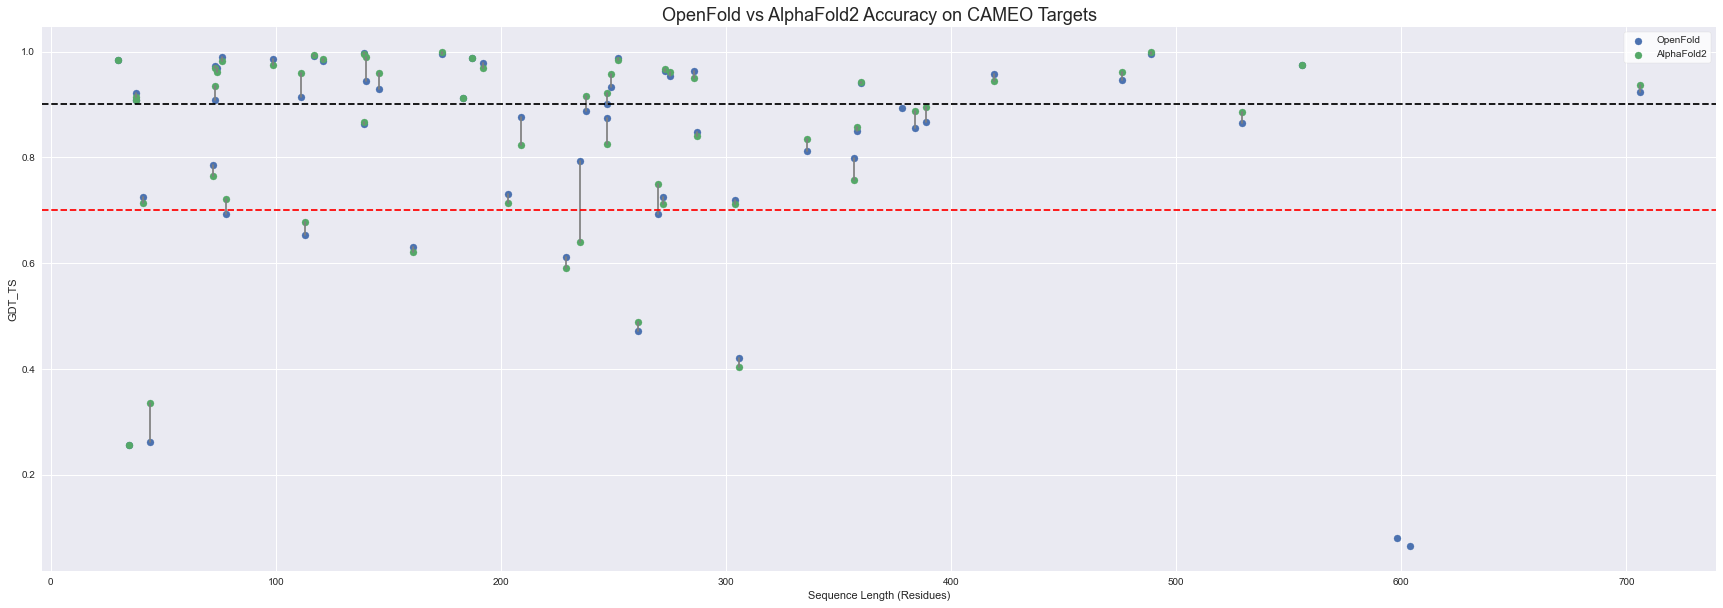

In [32]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(30,10))

x = results["SEQ_LENGTH"]
y1 = results["openfold_gdt"]
y2 = results["alphafold2_gdt"]
ax.scatter(x, y1, label="OpenFold")
ax.scatter(x, y2, label="AlphaFold2")

X_line_coords = np.array([
    x,
    x
])
Y_line_coords = np.array([
    y1,
    y2
])
ax.plot(X_line_coords, Y_line_coords, color="gray")

ax.axhline(0.9, color="black", linestyle="--")
ax.axhline(0.7, color="red", linestyle="--")
ax.legend(frameon=True, facecolor="white")
ax.set_xlabel("Sequence Length (Residues)")
ax.set_ylabel("GDT_TS")
plt.title("OpenFold vs AlphaFold2 Accuracy on CAMEO Targets", fontsize=18)
plt.show()

### Compare run times

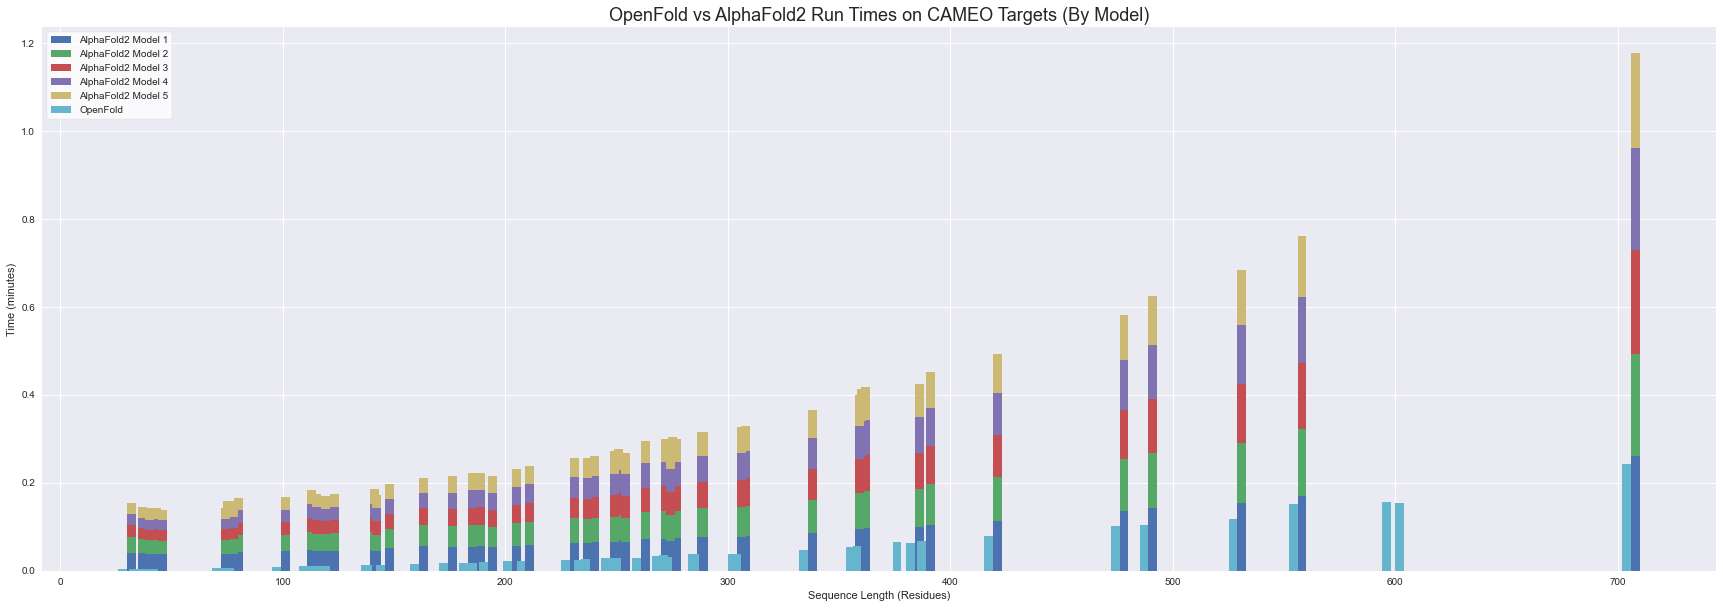

In [33]:
for i in range(1,6):
    results[f"alphafold_time_{i}"] = results[f"process_features_model_{i}_ptm_pred_0"] + results[f"predict_and_compile_model_{i}_ptm_pred_0"] + results[f"relax_model_{i}_ptm_pred_0"]

results["alphafold_time"] = results["alphafold_time_1"] + results["alphafold_time_2"]+ results["alphafold_time_3"]+ results["alphafold_time_4"]+ results["alphafold_time_5"]
results["openfold_time"] = results["inference"] + results["relaxation"]
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(30,10))

x = results["SEQ_LENGTH"]
y1 = results["alphafold_time_1"] / 3600
y2 = results["alphafold_time_2"] / 3600
y3 = results["alphafold_time_3"] / 3600
y4 = results["alphafold_time_4"] / 3600
y5 = results["alphafold_time_5"] / 3600
y6 = results["openfold_time"] / 3600

width = 4

ax.bar(x + width/2, y1, width, label="AlphaFold2 Model 1")
ax.bar(x + width/2, y2, width, bottom=y1, label="AlphaFold2 Model 2")
ax.bar(x + width/2, y3, width, bottom=y1+y2, label="AlphaFold2 Model 3")
ax.bar(x + width/2, y4, width, bottom=y1+y2+y3, label="AlphaFold2 Model 4")
ax.bar(x + width/2, y5, width, bottom=y1+y2+y3+y4, label="AlphaFold2 Model 5")
ax.bar(x - width/2, y6, width, label="OpenFold")

ax.legend(frameon=True, facecolor="white")
ax.set_xlabel("Sequence Length (Residues)")
ax.set_ylabel("Time (minutes)")
plt.title("OpenFold vs AlphaFold2 Run Times on CAMEO Targets (By Model)", fontsize=18)
plt.show()

-----

## Repeat analysis for missing AlphaFold targets

In [4]:
targets = pd.read_csv("1_month_cameo_benchmarking_targets_alphafold_makeup.csv", header=0)    

In [3]:
import requests 
from Bio import SeqIO
from io import StringIO

for _, row in targets.iterrows():
    print(row["SEQ_ID"])
    target = BatchFoldTarget(target_id=row["SEQ_ID"], s3_bucket=S3_BUCKET, boto_session=boto_session)    
    fasta_string = requests.get(row["SEQ_URL"]).content.decode("utf-8")
    with StringIO(fasta_string) as fasta:
        for record in SeqIO.parse(fasta, "fasta"):
            target.add_sequence(
                seq_id=row["SEQ_ID"],
                seq=str(record.seq),
                description=record.description
            )

    job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
    alphafold2_job = AlphaFold2Job(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri(),
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        model_preset = "monomer_ptm",    
        benchmark = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )    

    alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue")

7V2S_B
7WUA_A
7ESG_A
7VKK_A


In [24]:
import requests 
from Bio import SeqIO
from io import StringIO

for _, row in targets.query("PDB_ID in ['7WUA', '7ESG']").iterrows():
    print(row["SEQ_ID"])
    target = BatchFoldTarget(target_id=row["SEQ_ID"], s3_bucket=S3_BUCKET, boto_session=boto_session)    
    fasta_string = requests.get(row["SEQ_URL"]).content.decode("utf-8")
    with StringIO(fasta_string) as fasta:
        for record in SeqIO.parse(fasta, "fasta"):
            target.add_sequence(
                seq_id=row["SEQ_ID"],
                seq=str(record.seq),
                description=record.description
            )

    job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
    jackhmmer_job = JackhmmerJob(
        job_name = job_name,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        output_s3_uri = target.get_msas_s3_uri(),
        boto_session = boto_session,
        cpu = 16,
        memory = 31
    )

    job_name = target.target_id + "_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
    openfold_job = OpenFoldJob(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri(),
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        config_preset = "model_1_ptm",
        openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
        save_outputs = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )

    job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
    alphafold2_job = AlphaFold2Job(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri(),
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        model_preset = "monomer_ptm",    
        benchmark = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )    

    jackhmmer_submission = batch_environment.submit_job(jackhmmer_job, job_queue_name="GravitonOnDemandJobQueue")

    openfold_submission = batch_environment.submit_job(openfold_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])
    alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])    



7WUA_A
7ESG_A
